In [2]:
from detr_config import Config
from detr_factory import DETRFactory
from detr_file_manager import FileManager
from detr_model_loader import ModelLoader
from detr_data_source import DataSource
from detr_model_evaluator import ModelEvaluator
from detr_metrics import MetricsAggregator, metrics_names
from detr_detection import plot_comparison, plot_annotations
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold


Config.set_local_settings()

In [8]:
Config.LOGS_DIR = '../Otros/DETR_logs_data_augmentation/'
hyperparameters = ('D-DETR', 100, 6)
detr_factory = DETRFactory(*hyperparameters)
file_manager = FileManager(detr_factory)
model_loader = ModelLoader(detr_factory, file_manager)
data_source = DataSource(detr_factory, file_manager)
metrics_aggregator = MetricsAggregator(file_manager)

file_manager.set_testing_setup()
model = model_loader.load_best_model()
model_evaluator = ModelEvaluator(model, detr_factory)
id2label = model.detr.config.id2label

file_manager.set_validation_setup(fold=1)


train_dataset = data_source.get_train_dataset()

kfold = KFold(n_splits=Config.FOLDS, shuffle=True, random_state=123456)
kfold_split = kfold.split(train_dataset.ids)

trains_ids, valid_ids = kfold_split.__next__()
valid_dataset = data_source.get_valid_dataset(train_dataset, valid_ids)
valid_loader = data_source.get_dataloader(valid_dataset, valid_ids)

Loading Model:  ../Otros/DETR_logs_data_augmentation/model=D-DETR_queries=100_layers=6\test\checkpoints\epoch=96-step=582.ckpt
Loading Annotations from:  InBreast-COCO\train\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


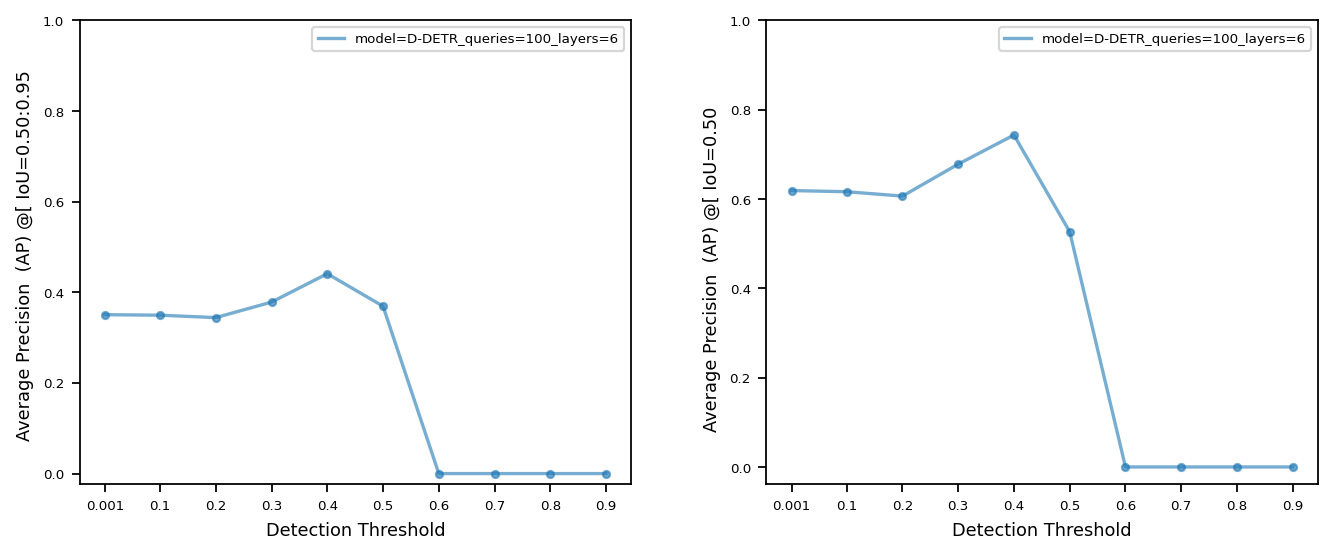

In [9]:
metrics = metrics_aggregator.load_metrics()

fig, axes = plt.subplots(1, 2, figsize=(9,4), dpi=160)
fig.tight_layout(pad=3)
axes = axes.flat

for i, metric in enumerate(metrics_names[0:2]):
    metrics_name = metric.split("|")[0]
    ax = axes[i]
    model_name = detr_factory.get_model_name()
    ax.plot(metrics.index, metrics[metric], alpha=0.6, label=model_name)
    ax.scatter(metrics.index, metrics[metric], alpha=0.6, s=10)
    
    ax.legend(fontsize=6)

    y_ticks = np.round(np.arange(0,1.1,0.2), 1)
    x_ticks = metrics.index
    ax.set_yticks(y_ticks, labels=y_ticks, fontsize=6)
    ax.set_xticks(x_ticks, labels=x_ticks, fontsize=6)

    ax.set_xlabel("Detection Threshold", fontsize=8)
    ax.set_ylabel(metrics_name, fontsize=8)

In [10]:
for batch in valid_loader:
    batch_predictions = model_evaluator.generate_predictions(batch, threshold=0.3)
    for i, (image_id, predictions) in enumerate(batch_predictions.items()):
        pixel_values, annotations = valid_loader.__getitem__(image_id)
        plot_comparison(pixel_values, annotations, predictions, id2label)

NameError: name 'test_loader' is not defined

In [11]:
model_evaluator.evaluate(valid_dataset, valid_loader, threshold=0.001)

Evaluating on threshold:  0.001
Accumulating evaluation results...
DONE (t=0.02s).


{'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]': 0.612,
 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]': 0.852,
 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]': 0.724,
 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]': 0.451,
 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]': 0.61,
 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]': 0.885,
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]': 0.6,
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]': 0.755,
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]': 0.755,
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]': 0.6,
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]': 0.717,
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]': 0.933}